In [1]:
%%capture
!pip install datasets transformers
!pip install sentencepiece

In [2]:
import datasets
import transformers
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead
import torch.optim as optim
import re
import random

from nltk.tokenize import sent_tokenize

import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Loading Data

In [4]:
def get_cnn_data(train_split, val_split, test_split):
    train_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="train[:{}%]".format(train_split))
    val_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="validation[:{}%]".format(val_split))
    test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test[:{}%]".format(test_split))

    print("Training Data Count: {}".format(len(train_data)))
    print("Validation Data Count: {}".format(len(val_data)))
    print("Test Data Count: {}".format(len(test_data)))

    return train_data, val_data, test_data

In [5]:
CNN_data_train_2perc, CNN_data_val_5perc, CNN_data_test_5perc = get_cnn_data(2, 5, 5)

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


Training Data Count: 5742
Validation Data Count: 668
Test Data Count: 574


In [6]:
# Training Data
CNN_data_train_2perc

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 5742
})

In [7]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# EDA

In [8]:
df_train = pd.DataFrame({'Text': CNN_data_train_2perc['article'], 
                         'Reference_Summary': CNN_data_train_2perc['highlights'], 
                         "ID": CNN_data_train_2perc['id']})
df_train

,Text,Reference_Summary,ID
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a
...,...,...,...
5737,"MIAMI, Florida (CNN) -- Forecasters issued a t...",Bermuda on alert as Hurricane Bill gets closer...,c44a6373583f8cc849b1de1d6524265960b6f88c
5738,"KABUL, Afghanistan (CNN) -- Afghanistan offici...","26 people killed in election day violence, Afg...",4bc1bf16a3364ff70a41bb4d4d19a6c33e0937cd
5739,(CNN) -- Ten climbers have died on two mountai...,10 climbers have died on two mountains in nort...,28717158f348f514fc107f80b8434020a070f980
5740,(CNN) -- Kids dig in the sand at the beach all...,"Boy, 11, was digging a tunnel with friends on ...",f89ad628856f337b9faa1b4d7fd1c759e4051cb4


In [9]:
df_train['Text_Length'] = df_train['Text'].map(lambda x: len(tokenizer(x)['input_ids']))
df_train['Sum_Length'] = df_train['Reference_Summary'].map(lambda x: len(tokenizer(x)['input_ids']))
df_train

Token indices sequence length is longer than the specified maximum sequence length for this model (1196 > 1024). Running this sequence through the model will result in indexing errors


,Text,Reference_Summary,ID,Text_Length,Sum_Length
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,565,52
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,888,72
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,919,58
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,531,39
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,1196,57
...,...,...,...,...,...
5737,"MIAMI, Florida (CNN) -- Forecasters issued a t...",Bermuda on alert as Hurricane Bill gets closer...,c44a6373583f8cc849b1de1d6524265960b6f88c,496,59
5738,"KABUL, Afghanistan (CNN) -- Afghanistan offici...","26 people killed in election day violence, Afg...",4bc1bf16a3364ff70a41bb4d4d19a6c33e0937cd,1541,55
5739,(CNN) -- Ten climbers have died on two mountai...,10 climbers have died on two mountains in nort...,28717158f348f514fc107f80b8434020a070f980,208,53
5740,(CNN) -- Kids dig in the sand at the beach all...,"Boy, 11, was digging a tunnel with friends on ...",f89ad628856f337b9faa1b4d7fd1c759e4051cb4,294,65


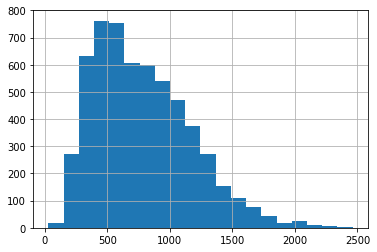

In [10]:
import matplotlib.pyplot as plt

df_train['Text_Length'].hist(bins=20)

In [11]:
np.percentile(df_train['Text_Length'], 95)

1492.8499999999995

In [12]:
df_train['Text_Length'].max()

2462

In [13]:
df_train['Text_Length'].min()

29

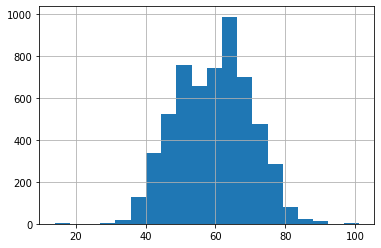

In [14]:
df_train['Sum_Length'].hist(bins=20)

In [15]:
df_train['Sum_Length'].max()

101

In [16]:
df_train['Sum_Length'].min()

14

# Preprocessing

In [17]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"], max_length=max_input_length, truncation=True
    )

    labels = tokenizer(
        examples["highlights"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [18]:
tokenized_datasets_train = CNN_data_train_2perc.map(preprocess_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [19]:
tokenized_datasets_train = tokenized_datasets_train.remove_columns(['article', 'highlights', 'id'])
tokenized_datasets_train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5742
})

In [20]:
tokenized_datasets_val = CNN_data_val_5perc.map(preprocess_function, batched=True)
tokenized_datasets_val = tokenized_datasets_val.remove_columns(['article', 'highlights', 'id'])
# tokenized_datasets_val.set_format(type='torch')
tokenized_datasets_val

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 668
})

In [21]:
tokenized_datasets_test = CNN_data_test_5perc.map(preprocess_function, batched=True)
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['article', 'highlights', 'id'])
# tokenized_datasets_test.set_format(type='torch')
tokenized_datasets_test

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 574
})

# Metrics

In [22]:
%%capture
!pip install evaluate
!pip install bert_score

In [23]:
import evaluate
from evaluate import load

bertscore = load("bertscore")

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    decoded_preds = ["".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["".join(sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute BERT scores
    result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

    # Extract the mean&median scores
    mean_result = {"bertscore-mean-" + key: np.mean(value) for key, value in result.items() if key in ['precision', 'recall', 'f1']}
    median_result = {"bertscore-median-" + key: np.median(value) for key, value in result.items() if key in ['precision', 'recall', 'f1']}

    results_dict = {k: round(v, 5) for k, v in mean_result.items()}
    results_dict.update({k: round(v, 5) for k, v in median_result.items()})

    return results_dict

## Metric Testing

In [ ]:
# Testing the bertscore metric

predictions = [" The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the United States opposed the Palestinians' efforts to join the court . Rights group Human Rights Watch welcomed the move, saying it was a step toward justice .",
 ' Theia is a one-year-old bully breed mix who was hit by a car and buried in a field . She was found by a worker who took her to a vet for help . She suffered a dislocated jaw, leg injuries and a caved-in sinus cavity . A fundraising page has raised enough money to pay for her treatment .',
 " Mohammad Javad Zarif is the Iranian foreign minister . He has helped secure a breakthrough in nuclear talks that could lead to an end to sanctions against Iran . Zarif received a hero's welcome as he arrived in Iran on a sunny Friday morning . But there are some facts about Zarif that are less well-known .",
 " The five were exposed to Ebola in Sierra Leone in March, but none developed the deadly virus . They are clinicians for Partners in Health, a Boston-based aid group . One of the five had a heart-related issue on Saturday and has been discharged but hasn't left the area .",
 ' A Duke student has admitted to hanging a noose from a tree near a student union, university officials say . The student was identified during an investigation by campus police and the office of student affairs . Officials are still trying to determine if other people were involved in the incident .']

references = ['Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .\nIsrael and the United States opposed the move, which could open the door to war crimes investigations against Israelis .',
 'Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field .\n"She\'s a true miracle dog and she deserves a good life," says Sara Mellado, who is looking for a home for Theia .',
 'Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister .\nHe once participated in a takeover of the Iranian Consulate in San Francisco .\nThe Iranian foreign minister tweets in English .',
 '17 Americans were exposed to the Ebola virus while in Sierra Leone in March .\nAnother person was diagnosed with the disease and taken to hospital in Maryland .\nNational Institutes of Health says the patient is in fair condition after weeks of treatment .',
 'Student is no longer on Duke University campus and will face disciplinary review .\nSchool officials identified student during investigation and the person admitted to hanging the noose, Duke says .\nThe noose, made of rope, was discovered on campus about 2 a.m.']

results = bertscore.compute(predictions=predictions, references=references, lang="en")

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

In [ ]:
results

{'precision': [0.9052074551582336,
  0.8744648098945618,
  0.8689237833023071,
  0.8744641542434692,
  0.8961836099624634],
 'recall': [0.9156136512756348,
  0.8897767663002014,
  0.8753549456596375,
  0.8845327496528625,
  0.8999384641647339],
 'f1': [0.9103808403015137,
  0.8820543885231018,
  0.8721275329589844,
  0.8794695734977722,
  0.8980571031570435],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.24.0)'}

In [ ]:
temp_var = {"bertscore-mean-" + key: np.mean(value) for key, value in results.items() if key in ['precision', 'recall', 'f1']}
temp_dict = {k: round(v, 5) for k, v in temp_var.items()}
temp_dict

{'bertscore-mean-precision': 0.88385,
 'bertscore-mean-recall': 0.89304,
 'bertscore-mean-f1': 0.88842}

In [ ]:
temp_var = {"bertscore-median-" + key: np.median(value) for key, value in results.items() if key in ['precision', 'recall', 'f1']}
temp_dict.update({k: round(v, 5) for k, v in temp_var.items()})
temp_dict

{'bertscore-mean-precision': 0.88385,
 'bertscore-mean-recall': 0.89304,
 'bertscore-mean-f1': 0.88842,
 'bertscore-median-precision': 0.87446,
 'bertscore-median-recall': 0.88978,
 'bertscore-median-f1': 0.88205}

# Training

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Model Ver2

In [ ]:
from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 1
num_train_epochs = 3
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets_train) // batch_size
# model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir="bart-base-finetuned-summarization-cnn-ver1.2",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:729: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  FutureWarning,
Cloning https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.2 into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5742
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 17226
  Number of trainable parameters = 139420416
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bertscore-mean-precision,Bertscore-mean-recall,Bertscore-mean-f1,Bertscore-median-precision,Bertscore-median-recall,Bertscore-median-f1
1,2.330500,2.212517,0.884540,0.858730,0.871260,0.883950,0.857660,0.870580
2,1.775100,2.202764,0.891030,0.861630,0.875900,0.890330,0.860330,0.874410
3,1.456400,2.247582,0.890410,0.861110,0.875330,0.889060,0.859980,0.874120


Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-500
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-500/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.2/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.2/special_tokens_map.json
Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-1000
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-1000/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-1000/pytorch_model.bin
tokenizer

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/pytorch_model.bin
All the weights of RobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.
Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-6000
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-6000/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-6000/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.2/checkpoint-6000/special_tokens_map.json
Deleting older checkpoint [bart-base-finetuned-summarization-cnn-

TrainOutput(global_step=17226, training_loss=1.8539820234492919, metrics={'train_runtime': 3854.8467, 'train_samples_per_second': 4.469, 'train_steps_per_second': 4.469, 'total_flos': 7286237541273600.0, 'train_loss': 1.8539820234492919, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.2
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.2/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.2/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.2/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.2/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/532M [00:00<?, ?B/s]

Upload file runs/Nov29_18-10-22_ed55cda93ff3/events.out.tfevents.1669745474.ed55cda93ff3.78.0:  44%|####3     …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.2
   7b252f4..0451e3b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.2
   7b252f4..0451e3b  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'cnn_dailymail', 'type': 'cnn_dailymail', 'config': '3.0.0', 'split': 'train[:2%]', 'args': '3.0.0'}}
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.2
   0451e3b..c67c7a7  main -> main

   0451e3b..c67c7a7  main -> main



'https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.2/commit/0451e3b69413050e025345371f58ca34744bca37'

### Outcome Checking

In [25]:
from transformers import pipeline

hub_model_id = "Alred/bart-base-finetuned-summarization-cnn-ver1.2"
summarizer = pipeline("summarization", model=hub_model_id)

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [26]:
def print_summary(idx):
    review = CNN_data_test_5perc[idx]["article"]
    reference = CNN_data_test_5perc[idx]["highlights"]
    summary = summarizer(CNN_data_test_5perc[idx]["article"])[0]["summary_text"]
    print(f"'>>> News Article: {review}'")
    print(f"\n'>>> Reference Summary: {reference}'")
    print(f"\n'>>> Generated Summary: {summary}'")

In [27]:
print_summary(2)

'>>> News Article: (CNN)If you've been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been U.S. Secretary of State John Kerry's opposite number in securing a breakthrough in nuclear discussions that could lead to an end to sanctions against Iran -- if the details can be worked out in the coming weeks. And he received a hero's welcome as he arrived in Iran on a sunny Friday morning. "Long live Zarif," crowds chanted as his car rolled slowly down the packed street. You may well have read that he is "polished" and, unusually for one burdened with such weighty issues, "jovial." An Internet search for "Mohammad Javad Zarif" and "jovial" yields thousands of results. He certainly has gone a long way to bring Iran in from the cold and allow it to rejoin the international community. But there are some facts about Zarif that are less well-known. Here are six: . In September 2013, Zarif twee

## Model Ver3

In [ ]:
from transformers import BartForConditionalGeneration

model3 = BartForConditionalGeneration.from_pretrained(model_checkpoint)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/pytorch_model.bin
All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BartForConditionalGeneration for predictions without further training.


In [ ]:
# Model Config
model3.config.task_specific_params = {
    'summarization': {'length_penalty': 1.2,
  'max_length': 142,
  'min_length': 56,
  'num_beams': 4}}

In [ ]:
model3.config.task_specific_params

{'summarization': {'length_penalty': 1.2,
  'max_length': 142,
  'min_length': 56,
  'num_beams': 4}}

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 1
num_train_epochs = 3
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets_train) // batch_size
# model_name = model_checkpoint.split("/")[-1]

args3 = Seq2SeqTrainingArguments(
    output_dir="bart-base-finetuned-summarization-cnn-ver1.3",
    evaluation_strategy="epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Seq2SeqTrainer

trainer3 = Seq2SeqTrainer(
    model3,
    args3,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:729: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  FutureWarning,
Cloning https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.3 into local empty directory.


In [ ]:
trainer3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5742
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 17226
  Number of trainable parameters = 139420416


Epoch,Training Loss,Validation Loss,Bertscore-mean-precision,Bertscore-mean-recall,Bertscore-mean-f1,Bertscore-median-precision,Bertscore-median-recall,Bertscore-median-f1
1,2.373500,2.258124,0.883130,0.858550,0.870480,0.883440,0.857310,0.870410
2,1.744000,2.247851,0.891970,0.861970,0.876530,0.890790,0.860330,0.875180
3,1.364300,2.314774,0.888960,0.860310,0.874220,0.887430,0.859730,0.872610


Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-500
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-500/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.3/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.3/special_tokens_map.json
Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-1000
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-1000/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.3/checkpoint-1000/pytorch_model.bin
tokenizer

TrainOutput(global_step=17226, training_loss=1.8272679708815889, metrics={'train_runtime': 3729.8536, 'train_samples_per_second': 4.618, 'train_steps_per_second': 4.618, 'total_flos': 7286237541273600.0, 'train_loss': 1.8272679708815889, 'epoch': 3.0})

In [ ]:
trainer3.push_to_hub(commit_message="Training complete", tags="summarization")

Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver1.3
Configuration saved in bart-base-finetuned-summarization-cnn-ver1.3/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver1.3/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver1.3/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver1.3/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/532M [00:00<?, ?B/s]

Upload file runs/Nov30_01-28-29_0af377443dd4/events.out.tfevents.1669771732.0af377443dd4.337.1:  45%|####5    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.3
   09afdda..222cd2c  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.3
   09afdda..222cd2c  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'cnn_dailymail', 'type': 'cnn_dailymail', 'config': '3.0.0', 'split': 'train[:2%]', 'args': '3.0.0'}}
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.3
   222cd2c..82e7f18  main -> main

   222cd2c..82e7f18  main -> main



'https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver1.3/commit/222cd2c29979867a7e2b314977f093037305d8ff'

### Outcome Checking

In [28]:
from transformers import pipeline

hub_model_id = "Alred/bart-base-finetuned-summarization-cnn-ver1.3"
summarizer = pipeline("summarization", model=hub_model_id)

Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [29]:
def print_summary(idx):
    review = CNN_data_test_5perc[idx]["article"]
    reference = CNN_data_test_5perc[idx]["highlights"]
    summary = summarizer(CNN_data_test_5perc[idx]["article"])[0]["summary_text"]
    print(f"'>>> News Article: {review}'")
    print(f"\n'>>> Reference Summary: {reference}'")
    print(f"\n'>>> Generated Summary: {summary}'")

In [30]:
print_summary(2)

'>>> News Article: (CNN)If you've been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been U.S. Secretary of State John Kerry's opposite number in securing a breakthrough in nuclear discussions that could lead to an end to sanctions against Iran -- if the details can be worked out in the coming weeks. And he received a hero's welcome as he arrived in Iran on a sunny Friday morning. "Long live Zarif," crowds chanted as his car rolled slowly down the packed street. You may well have read that he is "polished" and, unusually for one burdened with such weighty issues, "jovial." An Internet search for "Mohammad Javad Zarif" and "jovial" yields thousands of results. He certainly has gone a long way to bring Iran in from the cold and allow it to rejoin the international community. But there are some facts about Zarif that are less well-known. Here are six: . In September 2013, Zarif twee

## Model Ver4

In [ ]:
from transformers import BartForConditionalGeneration

model3 = BartForConditionalGeneration.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 1
num_train_epochs = 1
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets_train) // batch_size
# model_name = model_checkpoint.split("/")[-1]

args3 = Seq2SeqTrainingArguments(
    output_dir="bart-base-finetuned-summarization-cnn-ver3",
    evaluation_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import Seq2SeqTrainer

trainer3 = Seq2SeqTrainer(
    model3,
    args3,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:729: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  FutureWarning,
Cloning https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver3 into local empty directory.


In [ ]:
trainer3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5742
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 5742
  Number of trainable parameters = 139420416
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bertscore-mean-precision,Bertscore-mean-recall,Bertscore-mean-f1,Bertscore-median-precision,Bertscore-median-recall,Bertscore-median-f1
1,3.632000,2.982719,0.881080,0.855410,0.867890,0.880880,0.854460,0.866950


Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver3/checkpoint-500
Configuration saved in bart-base-finetuned-summarization-cnn-ver3/checkpoint-500/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver3/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver3/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver3/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver3/special_tokens_map.json
Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver3/checkpoint-1000
Configuration saved in bart-base-finetuned-summarization-cnn-ver3/checkpoint-1000/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver3/checkpoint-1000/pytorch_model.bin
tokenizer config file saved i

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/pytorch_model.bin
All the weights of RobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=5742, training_loss=3.6320396856495996, metrics={'train_runtime': 1339.4253, 'train_samples_per_second': 4.287, 'train_steps_per_second': 4.287, 'total_flos': 2428745847091200.0, 'train_loss': 3.6320396856495996, 'epoch': 1.0})

In [ ]:
trainer3.evaluate()

***** Running Evaluation *****
  Num examples = 668
  Batch size = 8


{'eval_loss': 2.1071815490722656,
 'eval_bertscore-mean-precision': 0.88615,
 'eval_bertscore-mean-recall': 0.85919,
 'eval_bertscore-mean-f1': 0.8723,
 'eval_bertscore-median-precision': 0.88513,
 'eval_bertscore-median-recall': 0.85817,
 'eval_bertscore-median-f1': 0.87189,
 'eval_runtime': 65.623,
 'eval_samples_per_second': 10.179,
 'eval_steps_per_second': 1.28,
 'epoch': 5.0}

In [ ]:
trainer3.push_to_hub(commit_message="Training complete", tags="summarization")

Saving model checkpoint to bart-base-finetuned-summarization-cnn-ver3
Configuration saved in bart-base-finetuned-summarization-cnn-ver3/config.json
Model weights saved in bart-base-finetuned-summarization-cnn-ver3/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-summarization-cnn-ver3/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-summarization-cnn-ver3/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/532M [00:00<?, ?B/s]

Upload file runs/Nov29_03-37-54_78f0b22dd118/events.out.tfevents.1669693108.78f0b22dd118.78.0:  56%|#####5    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver3
   15d2f01..4cc57cf  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver3
   15d2f01..4cc57cf  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'cnn_dailymail', 'type': 'cnn_dailymail', 'config': '3.0.0', 'split': 'train[:2%]', 'args': '3.0.0'}}
To https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver3
   4cc57cf..aa26296  main -> main

   4cc57cf..aa26296  main -> main



'https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-ver3/commit/4cc57cfb3e3d829c7ebfd91f50ed7ccb46649c8c'

### Outcome Checking

In [31]:
from transformers import pipeline

hub_model_id = "Alred/bart-base-finetuned-summarization-cnn-ver3"
summarizer = pipeline("summarization", model=hub_model_id)

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [32]:
def print_summary(idx):
    review = CNN_data_test_5perc[idx]["article"]
    reference = CNN_data_test_5perc[idx]["highlights"]
    summary = summarizer(CNN_data_test_5perc[idx]["article"])[0]["summary_text"]
    print(f"'>>> News Article: {review}'")
    print(f"\n'>>> Reference Summary: {reference}'")
    print(f"\n'>>> Generated Summary: {summary}'")

In [33]:
print_summary(2)

'>>> News Article: (CNN)If you've been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been U.S. Secretary of State John Kerry's opposite number in securing a breakthrough in nuclear discussions that could lead to an end to sanctions against Iran -- if the details can be worked out in the coming weeks. And he received a hero's welcome as he arrived in Iran on a sunny Friday morning. "Long live Zarif," crowds chanted as his car rolled slowly down the packed street. You may well have read that he is "polished" and, unusually for one burdened with such weighty issues, "jovial." An Internet search for "Mohammad Javad Zarif" and "jovial" yields thousands of results. He certainly has gone a long way to bring Iran in from the cold and allow it to rejoin the international community. But there are some facts about Zarif that are less well-known. Here are six: . In September 2013, Zarif twee

# Performance on the Test Dataset

In [ ]:
from transformers import BartForConditionalGeneration
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer


loaded_model = BartForConditionalGeneration.from_pretrained("Alred/bart-base-finetuned-summarization-cnn-ver1.2")

loaded_model.config.task_specific_params = {
    "summarization": {
      "length_penalty": 1.2,
      "max_length": 142,
      "min_length": 56,
      "num_beams": 4
    }}

# data_collator = DataCollatorForSeq2Seq(tokenizer, model=loaded_model)

batch_size = 1
num_train_epochs = 0
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets_train) // batch_size
# model_name = model_checkpoint.split("/")[-1]

loaded_args = Seq2SeqTrainingArguments(
    output_dir="bart-base-finetuned-summarization-cnn-404",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    predict_with_generate=True,
    push_to_hub=True,
)

loaded_trainer = Seq2SeqTrainer(
    loaded_model,
    loaded_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test, # evaluated on test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/content/bart-base-finetuned-summarization-cnn-404 is already a clone of https://huggingface.co/Alred/bart-base-finetuned-summarization-cnn-404. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
loaded_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 574
  Batch size = 1
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/pytorch_model.bin
All the weights of RobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


{'eval_loss': 2.26542067527771,
 'eval_bertscore-mean-precision': 0.89118,
 'eval_bertscore-mean-recall': 0.8603,
 'eval_bertscore-mean-f1': 0.87531,
 'eval_bertscore-median-precision': 0.89181,
 'eval_bertscore-median-recall': 0.85851,
 'eval_bertscore-median-f1': 0.87393,
 'eval_runtime': 189.0529,
 'eval_samples_per_second': 3.036,
 'eval_steps_per_second': 3.036}